In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Consider sampling a target mixture distribution

In [10]:
import lic.ppl as ppl
import torch
import torch.distributions as dist

@ppl.random_variable
def x():
    return dist.MixtureSameFamily(
        dist.Categorical(probs=torch.tensor(
            [0.35, 0.65]
        )),
        dist.Independent(dist.Normal(
            torch.tensor([0., 10.]),
            torch.tensor([1, 1.]),
        ), 0)
    )

In [14]:
import lic.ppl.experimental.inference_compilation.ic_infer as ic_infer
import torch.optim as optim

ic = ic_infer.ICInference().compile(
    observation_keys=[],
    query_hints=[x()],
    num_worlds=1e4,
    gmm_num_components=10,
    batch_size=16,
    optimizer_func=lambda x: optim.Adam(x, lr=1e-3, weight_decay=1e-3)
)

Loss: tensor([0.])


In [15]:
import pandas as pd


df = pd.DataFrame()
for (method, infer_instance) in [
    # redacted
    ("LIC (this paper)", ic)
]:
    samples = infer_instance.infer(
        [x()],
        {},
        num_samples=1000,
        num_adaptive_samples=100,
        num_chains=1,
    )
    df = df.append(pd.DataFrame({
        'x': samples[x()].flatten().numpy(),
        'method': method,
    }))

In [14]:
import pystan

code = """
parameters {
    real y;
}
model {
    target += log_mix(
        [0.35, 0.65], [
            normal_lpdf(y | 0, 1.0),
            normal_lpdf(y | 10, 1.0)
        ]);
}
"""
sm = pystan.StanModel(model_code=code)
fit = sm.sampling(data={}, iter=1000, chains=1)
df = df.append(pd.DataFrame({
    'x': fit.to_dataframe()["y"],
    'method': 'NUTS (Stan w/ defaults)'
}))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b913ec2fe33f6ba7a61a8d84ecf0eb12 NOW.


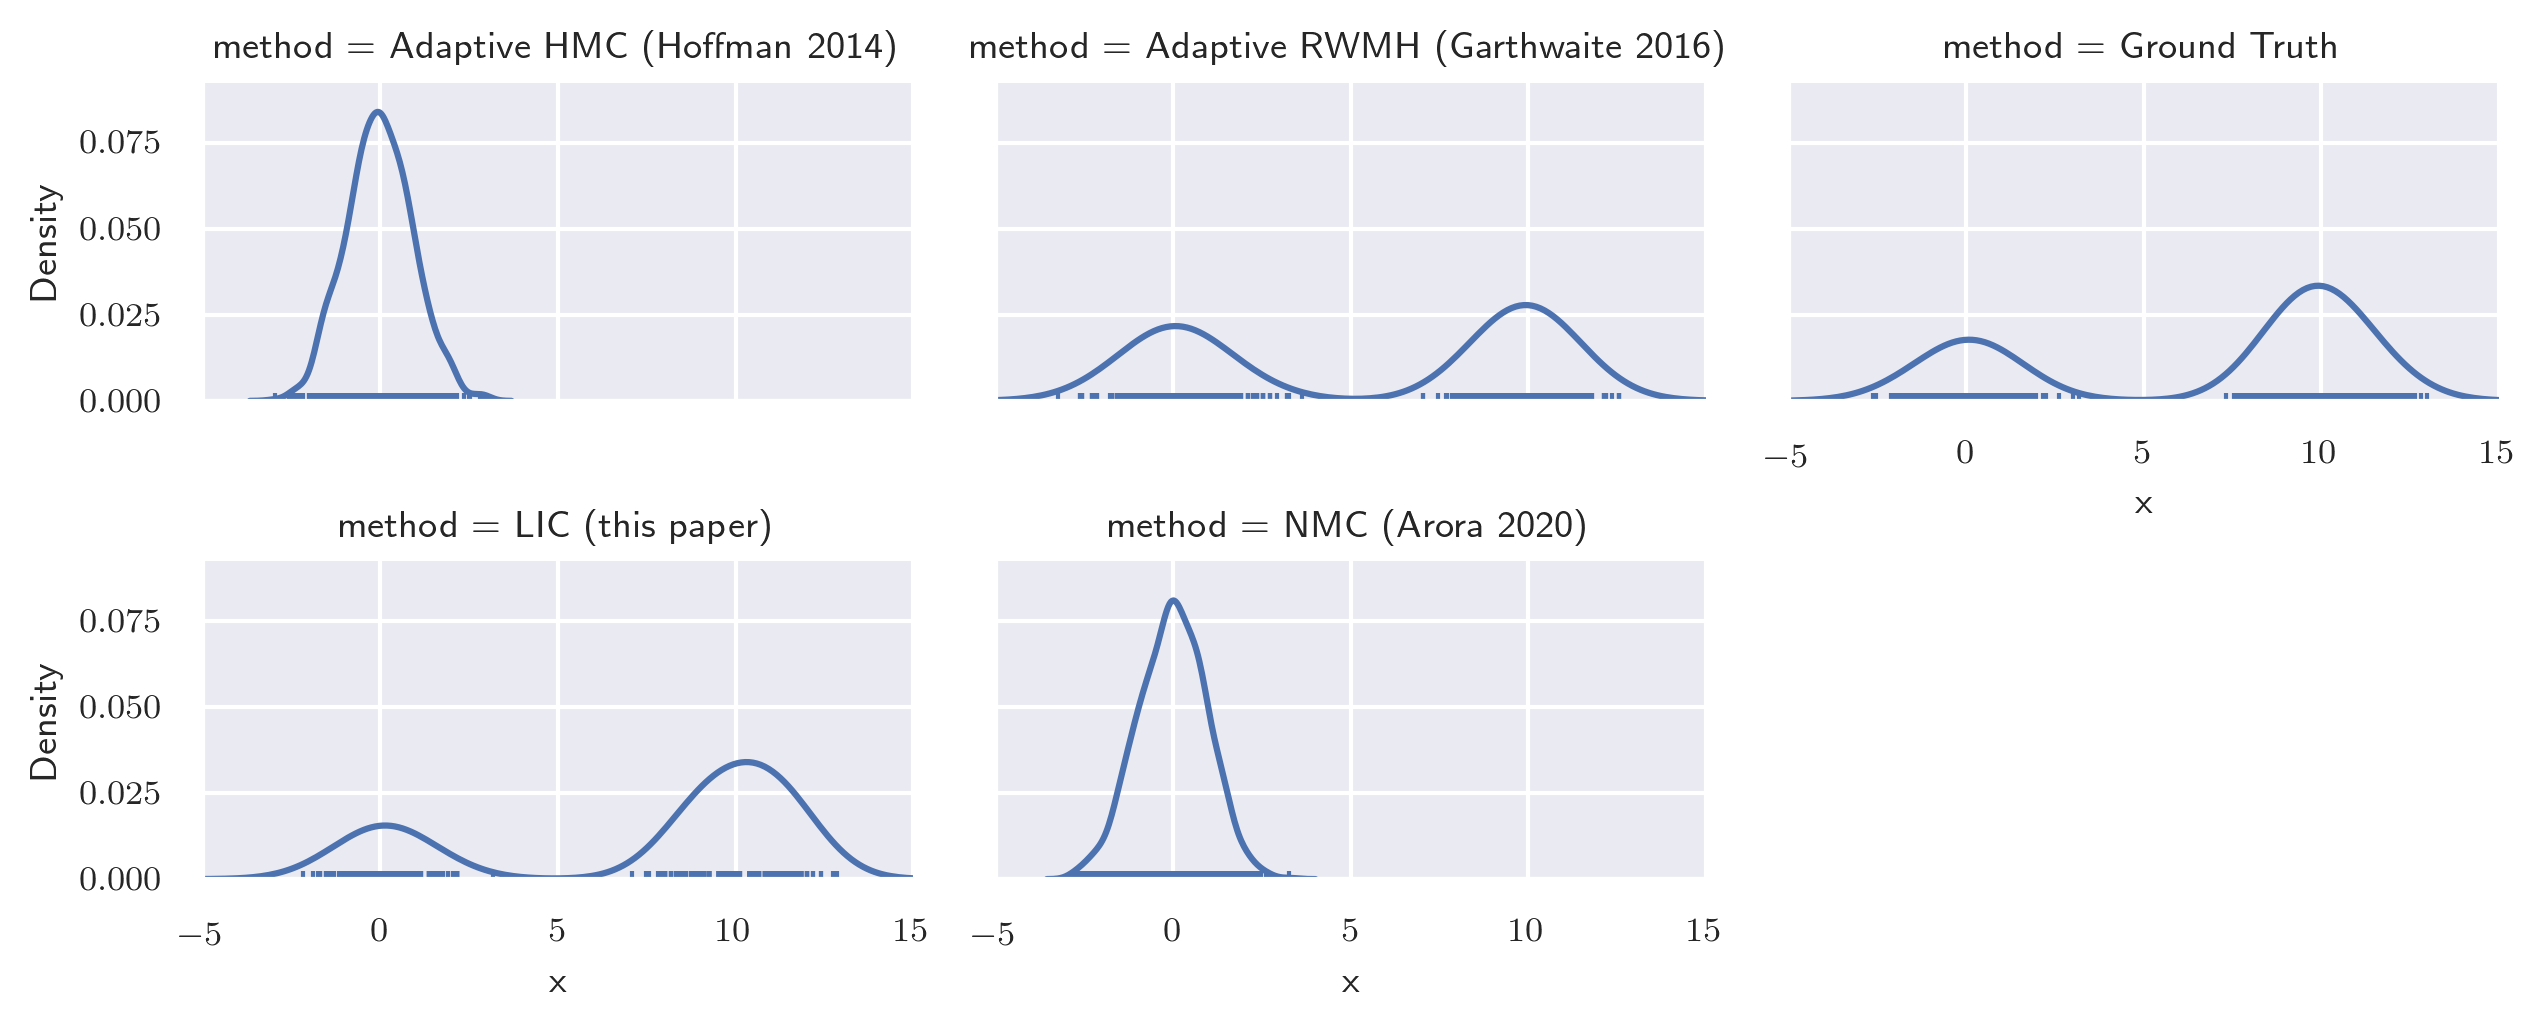

In [13]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": False,
})

import seaborn as sns
sns.set_style("darkgrid")
sns.set(font_scale=0.75)

df = df.sort_values(by="method")
import pickle
pickle.dump(df, open("outputs/gmm_escape.pkl", "wb"))
df = pickle.load(open("outputs/gmm_escape.pkl", "rb"))
fig = sns.displot(data=df, x='x', rug=True, kind="kde",
                  col='method',
                  col_wrap=3)
                  #hue='method',)

fig.set(xlim=(-5, 15))
fig.fig.set_size_inches(8.5, 3.5)
fig.fig.set_dpi(300)


fig.tight_layout()
fig.savefig('mode_escape.pdf', dpi=300)